In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import heapq
import geopandas as gpd
import plotly.graph_objects as go
import copy
import geopy
import multiprocessing
from joblib import Parallel, delayed

In [2]:
# read the csv file

# the simple one 
roads_df = gpd.read_file('data/ubcv_roads_simple.geojson')

# the complex one
# roads_df = gpd.read_file('data/ubcv_routes.geojson')

<Axes: >

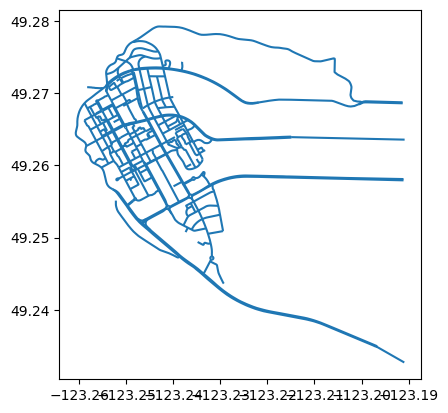

In [3]:
roads_df.plot()

In [4]:
buildings_df = pd.read_csv('data/ubcv_buildings_simple.csv')
otherBuildings_df = pd.read_csv('data/ubcv_poi.csv')
otherBuildings_df["BLDG_CODE"] = otherBuildings_df["PLACENAME"]

# clean up otherBuildings_df

# combine all dataframes
# should be avoided
df = pd.concat([roads_df, buildings_df], axis=0, ignore_index=True)


In [5]:
buildings_df = buildings_df.drop(columns=["PRIMARY_ADDRESS", "POSTAL_CODE", "CONSTR_STATUS", "BLDG_USAGE"])
buildings_df.head()

NAME BLDG_CODE  BLDG_UID         LAT  \
0                        Crescent West      CRSW  VBL10219 -123.232799   
1             Binning Tower - Highrise      BINH  VBL10210 -123.231374   
2  Brock Commons East - Tallwood House      BRCE  VBL10212 -123.251313   
3               South Campus Warehouse      SCWH  VBL10077 -123.231863   
4          Lower Mall Research Station      LMRS  VBL10100 -123.255524   

        LONG  
0  49.253131  
1  49.255441  
2  49.269507  
3  49.246256  
4  49.260553

In [6]:
otherBuildings_df["NAME"] = otherBuildings_df["PLACENAME"]
otherBuildings_df = otherBuildings_df.drop(columns=["BCN_CLASS", "BCN_LANDUSE", "BCN_CODE", "BCN_NOEMP", "LAST_EDITED_DATE", "LAST_EDITED_USER", "URL", "PHOTOURL", "SERVICE_TYPE", "BL_CLASS", "BL_NAME", "ABBREVIATEDPLACENAME", "PLACENAME2", "CREATED_USER", "LEED", "HTML", "STATUS", "MANAGE", "LICENSE", "HOURS", "PLACENAME", "CREATED_DATE", "CONTACT", "GLOBALID"])

otherBuildings_df.head()

POI_ID    ADD_ID         LAT       LONG  \
0  VPOI10314  VAD10774 -123.236480  49.254508   
1  VPOI10431  VAD11148 -123.248811  49.269372   
2  VPOI10322  VAD10364 -123.258521  49.264815   
3  VPOI10434  VAD10450 -123.248569  49.269278   
4  VPOI10294  VAD11095 -123.252735  49.257929   

                            BLDG_CODE                                NAME  
0                UBC Properties Trust                UBC Properties Trust  
1                         Stay at UBC                         Stay at UBC  
2                   Vanier Front Desk                   Vanier Front Desk  
3  Saltwater/k̓ʷaƛ̓kʷəʔaʔɬ Front Desk  Saltwater/k̓ʷaƛ̓kʷəʔaʔɬ Front Desk  
4                    Totem Front Desk                    Totem Front Desk

In [7]:
buildings_df = pd.concat([buildings_df, otherBuildings_df], axis=0, ignore_index=True)
buildings_df["IS_BUILDING"] = True
buildings_df.tail()

NAME  \
921                                     Blue Chip Cafe   
922                                      Kyros Kitchen   
923                               Shapecut Hair Design   
924  Peter Wall Institute for Advanced Studies (PWIAS)   
925                Clean Energy Research Centre (CERC)   

                                             BLDG_CODE BLDG_UID         LAT  \
921                                     Blue Chip Cafe      NaN -123.249873   
922                                      Kyros Kitchen      NaN -123.249760   
923                               Shapecut Hair Design      NaN -123.249447   
924  Peter Wall Institute for Advanced Studies (PWIAS)      NaN -123.256806   
925                Clean Energy Research Centre (CERC)      NaN -123.247643   

          LONG     POI_ID    ADD_ID  IS_BUILDING  
921  49.266236  VPOI10094  VAD10616         True  
922  49.266773  VPOI10217  VAD10616         True  
923  49.266478  VPOI10478  VAD10616         True  
924  49.268932  VPOI10485  VAD10032         True  
925  49.262525  VPOI10514  VAD10708         True

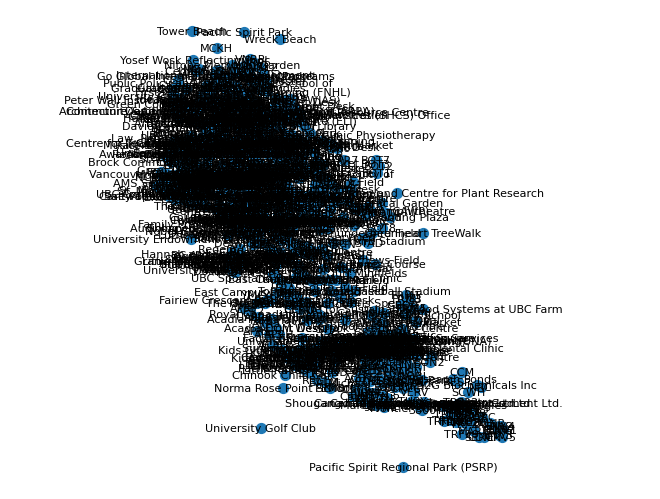

In [8]:
# create a graph

G = nx.Graph()
'''
# add nodes
for i in range(len(df)):
    if df["NAME"][i] == None:
        G.add_node("NaN", pos=(df["LONG"][i], df["LAT"][i]))
    else:
        G.add_node(df['NAME'][i], pos=(df['LONG'][i], df['LAT'][i]))
'''

for i in range(len(buildings_df)):
    
    G.add_node(buildings_df["BLDG_CODE"][i], pos=(-buildings_df["LONG"][i], -buildings_df["LAT"][i]))

# draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)

# Ensure equal aspect ratio
plt.axis('equal')

plt.show()

In [9]:
def calculate_distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def create_fig(edge_trace=[], node_trace=None, name="", width=1200, height=1200):
    data = []

    # Handle edge traces (list of traces or a single trace)
    if isinstance(edge_trace, list):
        data.extend(edge_trace)  # Add all traces in the list
    elif isinstance(edge_trace, (go.Scatter, go.Bar, go.Line)):  # Check if it's a valid trace type
        data.append(edge_trace)  # Add single trace
    else:
        raise ValueError("edge_trace must be a list of traces or a single valid Plotly trace object.")

    # Handle node trace (single trace)
    if isinstance(node_trace, (go.Scatter, go.Bar, go.Line)):  # Check for valid node trace type
        data.append(node_trace)  # Add single node trace
    elif node_trace is not None:
        raise ValueError("node_trace must be a single valid Plotly trace object.")

    # Create the figure
    fig = go.Figure(data=data)

    # Set layout for equal aspect ratio
    fig.update_layout(
        title=name,
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        template="plotly_white",
        width=width,  # Set the width of the figure
        height=height   # Set the height of the figure
    )

    # Make the x and y scales the same to avoid distortion
    fig.update_xaxes(scaleanchor="y", scaleratio=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    return fig

def create_nodes(node_x, node_y, node_text, mode='markers', color = 'black'):
    if color == 'black':
        color = ['black'] * len(node_text)
        
    node_colors = [
        'red' if color == 'red' else 
        ('black' if text not in buildings_df["BLDG_CODE"].values else 'green')
        for text, color in zip(node_text, color)
    ]
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode=mode,
        marker=dict(
            size=10,
            color= node_colors,
            line=dict(width=2, color=node_colors)
        ),
        text=node_text,
        textposition="top center",
        hoverinfo='text'
    )
    return node_trace

def create_edges(edge_x, edge_y, color='#888', width = 1):
    edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=width, color=color),
    hoverinfo='none',
    mode='lines'
    )
    return edge_trace

In [10]:
# Create a graph
building_G = nx.Graph()

# Add nodes with positions
for i in range(len(buildings_df)):
    building_G.add_node(
        buildings_df["BLDG_CODE"][i], 
        pos=(buildings_df["LAT"][i], buildings_df["LONG"][i])
    )

# Extract positions of nodes
pos = nx.get_node_attributes(building_G, 'pos')


# Create node traces
node_x = [x for node, (x, y) in pos.items()]
node_y = [y for node, (x, y) in pos.items()]
node_text = [str(node) for node, (x, y) in pos.items()]

edge_trace = create_edges([], [])    
node_trace = create_nodes(node_x, node_y, node_text)
fig = create_fig(edge_trace, node_trace, name = "Building map, missing roads and edges", width=800, height=1200)

fig.show()

In [11]:
# Create a graph
roads_G = nx.Graph()

listOfCoords = []
# Add nodes with positions
for i in range(len(roads_df)):
    geometry = roads_df["geometry"][i]
    
    if geometry.geom_type == "LineString":
        # Iterate through coordinates in LineString
        for j, (long, lat) in enumerate(geometry.coords):
            if (long, lat) not in listOfCoords:
                if long > -123.2277783865:
                    continue
                listOfCoords.append((long, lat))
                name = roads_df["NAME"][i] if "NAME" in roads_df.columns and pd.notna(roads_df["NAME"][i]) else f"road_{i}"
                node_id = name + f"_point_{j}"  
                roads_G.add_node(
                    node_id,
                    pos=(long, lat)  # Add coordinates as positions
                )
    elif geometry.geom_type == "MultiLineString":
        # Iterate through each LineString in MultiLineString
        for j, line in enumerate(geometry.geoms):  # `geometry.geoms` gives LineString objects
            for k, (long, lat) in enumerate(line.coords):
                if (long, lat) not in listOfCoords:
                    if long > -123.2277783865:
                        continue
                    listOfCoords.append((long, lat))
                    name = roads_df["NAME"][i] if "NAME" in roads_df.columns and pd.notna(roads_df["NAME"][i]) else f"road_{i}"
                    node_id = name + f"_line_{j}_point_{k}"
                    roads_G.add_node(
                        node_id,
                        pos=(long, lat)  # Add coordinates as positions
                    )

# Extract positions of nodes
pos = nx.get_node_attributes(roads_G, 'pos')

node_x = [x for node, (x, y) in pos.items()]
node_y = [y for node, (x, y) in pos.items()]
node_text = [str(node) for node, (x, y) in pos.items()]

edge_trace = create_edges([], [])
node_trace = create_nodes(node_x, node_y, node_text)
fig = create_fig(edge_trace, node_trace, name = "Road map, missing buildings and edges")
fig.show()

In [12]:

merged_G_noedges = nx.Graph()

for node in roads_G.nodes(data=True):
    merged_G_noedges.add_node(node[0], pos=node[1]['pos'])

for node in building_G.nodes(data=True):
    merged_G_noedges.add_node(node[0], pos=node[1]['pos'])

# Extract positions of nodes for visualization
pos = nx.get_node_attributes(merged_G_noedges, 'pos')

node_x = [x for node, (x, y) in pos.items()]
node_y = [y for node, (x, y) in pos.items()]
node_text = [str(node) for node, (x, y) in pos.items()]

edge_x = []
edge_y = []
edge_trace = create_edges(edge_x, edge_y)
node_trace = create_nodes(node_x, node_y, node_text)

fig = create_fig(edge_trace, node_trace, name="Combined Building & Road Map, no edges", width=800, height=1200)

fig.show()


In [13]:
# Initialize the merged graph
import geopy.distance


merged_G = nx.Graph()

# Add nodes with positions from both graphs
for node, data in building_G.nodes(data=True):
    merged_G.add_node(node, pos=data['pos'])

for node, data in roads_G.nodes(data=True):
    merged_G.add_node(node, pos=data['pos'])

# Helper function to calculate distance
def calculate_distance(pos1, pos2):
    pos1 = (pos1[1], pos1[0])
    pos2 = (pos2[1], pos2[0])
    return geopy.distance.geodesic(pos1, pos2).meters

# Identify building and road nodes
buildings = {node for node in merged_G.nodes() if node in buildings_df["BLDG_CODE"].values}
roads = {node for node in merged_G.nodes() if node not in buildings}

NUM_CLOSEST_NODES = 3

# Function to find the NUM_CLOSEST_NODES closest roads for a given building
def closest_roads_for_building(building):
    building_coord = merged_G.nodes[building]['pos']
    distances = [
        (building, road, calculate_distance(building_coord, merged_G.nodes[road]['pos']))
        for road in roads
    ]
    distances.sort(key=lambda x: x[2])
    return distances[:NUM_CLOSEST_NODES]

# Parallelize calculating distances from buildings to roads
building_edges = Parallel(n_jobs=-1)(delayed(closest_roads_for_building)(building) for building in buildings)

# Add edges to the graph for buildings
for edges in building_edges:
    for building, road, distance in edges:
        merged_G.add_edge(building, road, weight=distance)

# Function to find the NUM_CLOSEST_NODES closest nodes for a given road
def closest_nodes_for_road(road1):
    road1_coord = merged_G.nodes[road1]['pos']
    distances = [
        (road1, node, calculate_distance(road1_coord, merged_G.nodes[node]['pos']))
        for node in merged_G.nodes() if node != road1
    ]
    distances.sort(key=lambda x: x[2])
    return distances[:NUM_CLOSEST_NODES]

# Parallelize calculating distances from roads to all other nodes
road_edges = Parallel(n_jobs=-1)(delayed(closest_nodes_for_road)(road1) for road1 in roads)

# Add edges to the graph for roads
for edges in road_edges:
    for road1, node, distance in edges:
        merged_G.add_edge(road1, node, weight=distance)

# Add additional edges to connect neighboring points within roads
for road in roads:
    if "line" in road:  # Multiline string
        roadName = road.split("_line_")[0]
        lineNum = int(road.split("_line_")[1].split("_point_")[0])
        pointNum = int(road.split("_point_")[1])
        
        # Check for previous point
        if pointNum > 0:
            prev_point_label = f"{roadName}_line_{lineNum}_point_{pointNum - 1}"
            if prev_point_label in roads:  # Check existence
                weight = calculate_distance(
                    merged_G.nodes[road]['pos'], merged_G.nodes[prev_point_label]['pos']
                )
                merged_G.add_edge(road, prev_point_label, weight=weight)

        # Check for next point
        next_point_label = f"{roadName}_line_{lineNum}_point_{pointNum + 1}"
        if next_point_label in roads:  # Check existence
            weight = calculate_distance(
                merged_G.nodes[road]['pos'], merged_G.nodes[next_point_label]['pos']
            )
            merged_G.add_edge(road, next_point_label, weight=weight)
    
    else:  # Single line string
        roadName = road.split("_point_")[0]
        split_road = road.split("_point_")
        if len(split_road) > 1:
            pointNum = int(split_road[1])
        else:
            continue
        
        # Check for previous point
        if pointNum > 0:
            prev_point_label = f"{roadName}_point_{pointNum - 1}"
            if prev_point_label in roads:  # Check existence
                weight = calculate_distance(
                    merged_G.nodes[road]['pos'], merged_G.nodes[prev_point_label]['pos']
                )
                merged_G.add_edge(road, prev_point_label, weight=weight)

        # Check for next point
        next_point_label = f"{roadName}_point_{pointNum + 1}"
        if next_point_label in roads:  # Check existence
            weight = calculate_distance(
                merged_G.nodes[road]['pos'], merged_G.nodes[next_point_label]['pos']
            )
            merged_G.add_edge(road, next_point_label, weight=weight)

# Visualization part
combined_pos = nx.get_node_attributes(merged_G, 'pos')

node_x = [x for node, (x, y) in combined_pos.items()]
node_y = [y for node, (x, y) in combined_pos.items()]
node_text = [str(node) for node, (x, y) in combined_pos.items()]

# Extract edges to create edge traces
edge_x = []
edge_y = []
for edge in merged_G.edges(data=True):
    x0, y0 = combined_pos[edge[0]]
    x1, y1 = combined_pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_trace = create_nodes(node_x, node_y, node_text)
edge_trace = create_edges(edge_x, edge_y)
merged_fig = create_fig(edge_trace, node_trace, name="Merged Graph with Edges", width=800, height=1200)

merged_fig.show()

In [14]:
nx.is_connected(merged_G)

True

In [15]:
search_buildings = ["CRSW", "LSK"]
node_colors = []

# Iterate through node text to determine the color for each node
for text in node_trace.text:
    if text in search_buildings:
        node_colors.append('red')  # Set the color to red if the building is in search_buildings
        print(f"Building {text} found in the graph.")
    else:
        node_colors.append('blue')  # Default color is blue

node_trace = create_nodes(node_x, node_y, node_text, color=node_colors)
edge_trace = create_edges(edge_x, edge_y)
fig = create_fig(edge_trace, node_trace, name="Buildings are green, roads are black. Searched buildings are red.")
fig.show()


Building CRSW found in the graph.
Building LSK found in the graph.


In [16]:
# find the shortest path from one building to another with the weight
print(nx.shortest_path_length(merged_G, source=search_buildings[0], target=search_buildings[1], weight="weight"))

2594.019284942892


In [17]:
# color the shortest path in red

# Find the shortest path
shortest_path = nx.shortest_path(merged_G, source=search_buildings[0], target=search_buildings[1], weight="weight")

# Separate edges based on the shortest path
shortest_path_edges = set((shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1))

# Separate edge coordinates for edges in the shortest path and the rest
red_edge_x = []
red_edge_y = []
default_edge_x = []
default_edge_y = []

for edge in merged_G.edges():
    x0, y0 = combined_pos[edge[0]]
    x1, y1 = combined_pos[edge[1]]
    if edge in shortest_path_edges or (edge[1], edge[0]) in shortest_path_edges:
        red_edge_x.extend([x0, x1, None])
        red_edge_y.extend([y0, y1, None])
    else:
        default_edge_x.extend([x0, x1, None])
        default_edge_y.extend([y0, y1, None])

# Create edge traces
default_edge_trace = create_edges(default_edge_x, default_edge_y, color='#888')
red_edge_trace = create_edges(red_edge_x, red_edge_y, color='#ff0000', width=5)
                          
# Create a list of colors for each node
node_colors = []
for text in node_text:
    if text in search_buildings:
        node_colors.append('red')  # Set the color to red if the building is in search_buildings
    else:
        node_colors.append('blue')  # Default color is blue

# Create the node trace
node_trace = create_nodes(node_x, node_y, node_text, color=node_colors)

# Create a figure with the updated edge and node traces
fig = create_fig([default_edge_trace, red_edge_trace], node_trace, name="Shortest Path in Red")
fig.show()

In [18]:
A = nx.incidence_matrix(merged_G,oriented=True).toarray()
A

B = nx.adjacency_matrix(merged_G).toarray()
B

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        39.02756364,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 39.02756364,
         0.        , 28.54548336],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        28.54548336,  0.        ]], shape=(3491, 3491))

In [19]:
A.shape

(3491, 7559)

In [20]:
# check if an edge exists between CRSW and Gray Ave_point_15
print(merged_G.has_edge("Gray Ave_point_15", "CRSW"))
print(merged_G.has_edge("CRSW","Gray Ave_point_15"))

True
True


In [21]:
nodes = list(merged_G.nodes())
edges = list(merged_G.edges())

crsw_index = nodes.index("CRSW")
gray_ave_index = nodes.index("Gray Ave_point_15")

print(A[crsw_index][0])
print(A[gray_ave_index][0])

print(B[crsw_index][gray_ave_index])
print(B[gray_ave_index][crsw_index])

-1.0
1.0
40.576423996130096
40.576423996130096


In [22]:
A.shape

(3491, 7559)

In [23]:
test_G = nx.DiGraph()

test_G.add_edge(1, 2)
test_G.add_edge(2, 3)

test_A = nx.incidence_matrix(test_G,oriented=True).toarray()
test_A


array([[-1.,  0.],
       [ 1., -1.],
       [ 0.,  1.]])

In [24]:
#Capacity 
for edge in test_G.edges():
    test_G.edges[edge]['capacity'] = 1

In [25]:
test_G.nodes

NodeView((1, 2, 3))

In [26]:
type(nodes[0])
print(nodes[0])


CRSW


In [27]:
A_shape1 = A.shape[1]

# copy A to test_A
test_A = copy.deepcopy(A)
test_A = np.append(test_A, np.zeros((test_A.shape[0], test_A.shape[1])), axis=1)

for i in range(test_A.shape[0]):
    for j in range(A_shape1):
        if test_A[i][j] == 1: 
            test_A[i][j+A_shape1] = -1
        elif test_A[i][j] == -1:
            test_A[i][j+A_shape1] = 1
        else:
            test_A[i][j+A_shape1] = 0
            


Shortest Path linear programming

In [28]:
from scipy.optimize import linprog

def shortest_path_linear(building_o, building_d): 

    u_ij=1 #capacity of each edge

    b = np.zeros(len(nodes))
    b[nodes.index(building_o)] = 1
    b[nodes.index(building_d)] = -1

        
    c1=list(nx.get_edge_attributes(merged_G, 'weight').values()) #distance of each edge
    c=c1+c1 #distance of each edge in both directions

    result=linprog(c, A_eq=test_A, b_eq=b,bounds=(0, u_ij),method='highs') #highs is the faster version of simplex
    print("The shortest path is: ", result.x, "with a distance of:", result.fun)



In [29]:
shortest_path_linear("SRC", "LSK")


KeyboardInterrupt: 

Best Restaurant Problem

In [81]:
# R= {"ORCH", "VNR10", "TPR1"}
def best_restaurant(building_o, building_d):
    u_ij=1 #capacity of each edge
    R= ["ORCH", "VNR10", "TPR1"]
    num_restaurants = len(R)
    num_columns = test_A.shape[1]

    b = np.zeros(len(nodes))
    b[nodes.index(building_o)] = 1 #outgoing flow from the source   
    b[nodes.index(building_d)] = -1 #incoming flow to the destination

    new_A = np.concatenate((test_A, np.zeros((test_A.shape[0], num_restaurants))), axis=1)

    
    A_restaurant = np.zeros((num_restaurants, num_columns+num_restaurants))
    
    for r_idx,r in enumerate(R): #keep track of the restaurant index
        for col, edge in enumerate(edges): #keep track of the edge index
            if edge[1]==r:
                A_restaurant[r_idx][col] = 1 #incoming flow passes through the restaurant
            elif edge[0]==r:
             A_restaurant[r_idx][col] = -1 #outgoing flow passes through the restaurant
    
    b_restaurant = np.zeros(num_restaurants) #the restaurant is also cosidered as an intermediate node

    A_r = np.zeros((1, num_columns + num_restaurants))
    A_r[0, num_columns: num_columns+ num_restaurants] = 1  # Sum of all restaurants
    b_r = np.array([1])# sum of all restaurants is 1
        
    c1=list(nx.get_edge_attributes(merged_G, 'weight').values()) #distance of each edge
    c=c1+c1 #distance of each edge in both directions
    c_restaurant = c+[0]*num_restaurants #distance of each edge in both directions and the restaurant

    A_eq=np.vstack((new_A, A_restaurant, A_r))
    b_eq=np.hstack((b, b_restaurant, b_r))

    bounds = [(0, u_ij) for col in range(num_columns)] + [(0, 1) for r in range(num_restaurants)]

    #print("Shape of A_eq:", A_eq.shape) 
    #print("Shape of b_eq:", b_eq.shape) 
    # print("Objective function length:", len(c_restaurant))
    #print("Bounds length:", len(bounds))

    

    result=linprog(c_restaurant, A_eq=A_eq, b_eq=b_eq,bounds=bounds,method='highs')
    path = []
    for x in result.x[:-num_restaurants]: #return the path taken by the user
        if x>0:
            path.append(x)
            
    
    restaurant_index = np.argmax(result.x[-num_restaurants:])  # Get index of chosen restaurant np.argmax() retrun the index of the maximum value
    best_restaurant = R[restaurant_index]

    print("The best dining hall is", best_restaurant, "The shortest path is: ", path, "with a distance of:", result.fun)

    

In [82]:
best_restaurant("SRC", "LSK")

The best dining hall is ORCH The shortest path is:  [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)] with a distance of: 620.8421016828936


In [ ]:
# minimize sum_{s in S} dist(v, s) where S is the set of all buildings the people are in and v is every building
# also known as graph median problem

from typing import List, Tuple, Dict, Optional

def find_optimal_common_node(G, source_nodes, weight="weight"):
    """
    Finds the node in graph G that minimizes the total distance from all source nodes.
    
    Args:
        G (nx.Graph): The input weighted graph.
        source_nodes (List): A list of source nodes.
        weight (str): The edge attribute representing the weight. Default is 'weight'.
        
    Returns:
        Tuple containing:
            - optimal_node: The node that minimizes the total distance.
            - paths: A dictionary where keys are source nodes and values are the shortest paths to optimal_node.
            - distances: A dictionary where keys are source nodes and values are the distances to optimal_node.
    """
    if not source_nodes:
        raise ValueError("The list of source_nodes is empty.")
    
    # Initialize dictionaries to store distances and paths for each source
    all_distances = {}
    all_paths = {}
    
    # Compute shortest paths and distances from each source node
    for source in source_nodes:
        if source not in G:
            raise ValueError(f"Source node {source} is not in the graph.")
        try:
            distances, paths = nx.single_source_dijkstra(G, source, weight=weight)
            all_distances[source] = distances
            all_paths[source] = paths
        except nx.NetworkXNoPath:
            print(f"No paths found from source node {source}.")
            all_distances[source] = {}
            all_paths[source] = {}
    
    # Initialize variables to track the optimal node
    min_total_distance = float('inf')
    optimal_node = None
    
    # Iterate through all nodes to find the one with the smallest total distance
    for node in G.nodes():
        total_distance = 0
        feasible = True
        for source in source_nodes:
            distance = all_distances[source].get(node, None)
            if distance is None:
                # If any source node cannot reach this node, skip it
                feasible = False
                break
            total_distance += distance
        if feasible and total_distance < min_total_distance:
            min_total_distance = total_distance
            optimal_node = node
    
    if optimal_node is None:
        print("No common node found that is reachable from all source nodes.")
        return None, {}, {}
    
    # Retrieve paths and distances for the optimal node
    result_paths = {}
    result_distances = {}
    for source in source_nodes:
        path = nx.shortest_path(G, source, optimal_node, weight=weight)
        distance = all_distances[source][optimal_node]
        result_paths[source] = path
        result_distances[source] = distance
    
    return optimal_node, result_paths, result_distances

In [ ]:
source_nodes = ["LSK", "NEST", "MCLD", "UBC Studios", "CRSW", "Gray Ave_point_15", "OSB1", "SAG2"]
optimal_node, paths, distances = find_optimal_common_node(merged_G, source_nodes)

In [ ]:

print(f"Optimal Common Node: {optimal_node}")
for source in source_nodes:
    print(f"Path from {source} to {optimal_node}: {paths[source]} with distance {distances[source]}")
print(f"Total distance: {sum(distances.values())}")
# Collect all edges in all paths
path_edges = set()
for idx, (source, path) in enumerate(paths.items()):
    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        path_edges.add(edge)
        edge = (path[i + 1], path[i])  # Add reverse edge for undirected graph
        path_edges.add(edge)  


# Separate default edges and path edges
red_edge_x = []
red_edge_y = []
default_edge_x = []
default_edge_y = []


# Get all nodes positions
combined_pos = nx.get_node_attributes(merged_G, 'pos')

for edge in merged_G.edges():
    x0, y0 = combined_pos[edge[0]]
    x1, y1 = combined_pos[edge[1]]
    if edge in path_edges or (edge[1], edge[0]) in path_edges:
        red_edge_x.extend([x0, x1, None])
        red_edge_y.extend([y0, y1, None])
    else:
        default_edge_x.extend([x0, x1, None])
        default_edge_y.extend([y0, y1, None])

default_edge_trace = create_edges(default_edge_x, default_edge_y, color='#888')
red_edge_trace = create_edges(red_edge_x, red_edge_y, color='#ff0000', width=5)

# Create list of node coordinates and labels
node_x = [pos[0] for pos in combined_pos.values()]
node_y = [pos[1] for pos in combined_pos.values()]
node_text = [str(node) for node in merged_G.nodes()]

# Assign colors to nodes
node_colors = []
for node in merged_G.nodes():
    if node in source_nodes or node == optimal_node:
        node_colors.append('red')  # Highlight source nodes in red
    else:
        node_colors.append('black')  # Default node color

# Create node trace
node_trace = create_nodes(node_x=node_x, node_y = node_y, node_text = node_text, color=node_colors)

# Create the final figure
fig = create_fig([default_edge_trace, red_edge_trace], node_trace, name="Graph Median Problem")

# Show the figure
fig.show()

Optimal Common Node: Logan Ln_point_0
Path from LSK to Logan Ln_point_0: ['LSK', 'Sauder Ln_point_4', 'Sauder Ln_point_3', 'PUMP', 'Education Rd_point_1', 'Education Rd_point_2', 'THSP', 'road_216_point_0', 'road_216_point_1', 'Stores Rd_point_2', 'road_8_point_3', 'road_8_point_2', 'road_8_point_1', 'road_8_point_0', 'Hummingbird Child Care', 'Main Mall_point_1', 'Main Mall_point_2', 'Thunderbird Cres_point_11', 'Sopron Gate', 'Sopron Ln_point_0', 'Thunderbird Cres_point_7', 'Thunderbird Cres_point_5', 'THR2', 'Thunderbird Blvd_point_12', 'TAMK', 'Logan Ln_point_0'] with distance 1204.054849255649
Path from NEST to Logan Ln_point_0: ['NEST', 'road_37_point_3', 'Body Energy Club ', 'road_37_point_5', 'SBME', 'road_119_point_6', 'road_119_point_8', 'WLIB', 'Hospital Ln_point_3', 'Patient Park', 'road_99_point_0', 'road_135_point_0', 'Convergent Manufacturing Technologies', 'Agronomy Rd_point_9', 'Starbucks TEF3', 'East Mall_point_18', 'East Mall_point_15', 'Thunderbird Blvd_point_13', '